In [4]:
# Adding local Keras
import sys
import os
import numpy as np
from skimage import io
import itertools
from IPython.core.debugger import Tracer
%matplotlib inline
import matplotlib.pyplot as plt
KERAS_PATH = '/media/manish/Data/keras-master/'
sys.path.insert(0, KERAS_PATH)
sys.path.insert(0, os.path.join(KERAS_PATH, 'keras'))
sys.path.insert(0, os.path.join(KERAS_PATH, 'keras', 'layers'))
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
"""
data_weighted_loader consider the label for specific treatments
"""
def data_weighted_loader(path, batch_size, ignore_val=44, pos_val=255, neg_val=155, pos_class=3, neg_class=4):
    # pos_class and neg_class in the folder name for keras ImageDataGenerator input
    # 0,1,2 is for previous data. 3 and 4 is for new tcga data, which needs specific treatment

    def imerge(img_gen, mask_gen):
        
        for (img, img_labels), (mask, mask_labels) in itertools.izip(img_gen, mask_gen):
            Tracer()()
            
            # weight
            mask = np.expand_dims(mask[:,:,:,0], axis=3)
#             for img in mask:
#                 plt.figure()
#                 plt.imshow(img)
            print("Shape of the mask_labels: %s" % str(mask_labels))
            print("Shape of the label mask: %s" % str(mask.shape))
            
            weight = np.ones(mask.shape, np.float)
            weight[mask==ignore_val] = 0
            # In mask, ignored pixel has value ignore_val.
            # The weight of these pixel is set to zero, so they do not contribute to loss
            # The returned mask is still binary.

            # compute per sample
            for c, mask_label in enumerate(mask_labels):
                assert(mask_labels[c] == img_labels[c])
                mask_sample = mask[c]
                if mask_label == pos_class:
                    assert(np.where(mask_sample == neg_val)[0].size == 0)
                    mask_sample[mask_sample==pos_val] = 1
                elif mask_label == neg_class:
                    assert(np.where(mask_sample == pos_val)[0].size == 0)
                    mask_sample[mask_sample==neg_val] = 0
                else:
                	mask_sample /= 255

                mask_sample[mask_sample==ignore_val] = 0

            assert set(np.unique(mask)).issubset([0, 1])
            assert set(np.unique(weight)).issubset([0, 1])

            yield img/255.0, mask, weight, img_labels
            # yield norm_mean_img(img), mask, weight, img_labels

    train_data_gen_args = dict(
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.1,
                    fill_mode='reflect')

    seed = 1234
    train_image_datagen = ImageDataGenerator(**train_data_gen_args).flow_from_directory(
                                path+'train/img',
                                class_mode="sparse",
                                target_size=(512, 512),
                                batch_size=batch_size,
                                seed=seed)
    train_mask_datagen = ImageDataGenerator(**train_data_gen_args).flow_from_directory(
                                path+'train/groundtruth',
                                class_mode="sparse",
                                target_size=(512, 512),
                                batch_size=batch_size,
                                seed=seed)

    test_image_datagen = ImageDataGenerator().flow_from_directory(
                                path+'val/img',
                                class_mode="sparse",
                                target_size=(512, 512),
                                batch_size=batch_size,
                                seed=seed)
    test_mask_datagen = ImageDataGenerator().flow_from_directory(
                                path+'val/groundtruth',
                                class_mode="sparse",
                                target_size=(512, 512),
                                batch_size=batch_size,
                                seed=seed)

    train_generator = imerge(train_image_datagen, train_mask_datagen)
    test_generator = imerge(test_image_datagen, test_mask_datagen)

    return train_generator, test_generator

training_dir = './data/BladderData/Segmentation/'
batch_size = 5
train_generator, _ = data_weighted_loader(training_dir, batch_size)
x_batch, y_batch, weight, _ = train_generator.next()h

Reading annotation data...
(105152, 77248)
[24927.943177612142, 67587.24250757188, 29451.996678033167, 71033.69804896037]
[[25365.97787705752, 69394.95625832934],
 [25612.117393346474, 68373.66615259115]]
/media/manish/Data/Research/Breast Cancer Project/code/data/TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-9625-FCB55767B70D.svs
Creating offsets
Getting the mask
Reading whole slide section
(25109, 69138)
Creating offsets
Getting the mask
Reading whole slide section
(25356, 68117)


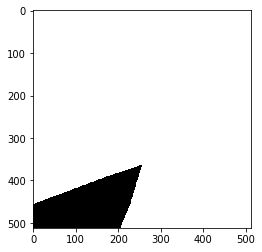

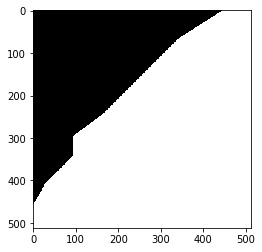

In [92]:
# Read the json file and whole slides and pick random points from annotation to crop the patch
# put positive patch in 1 folder and negative patch in 0 folder
import json
from pprint import pprint
from matplotlib import path as matpath
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.debugger import Tracer
import openslide_util as ou
import numpy as np
from PIL import Image

img_crop_size = 512;
offset_x_left = img_crop_size/2;
offset_y_top = img_crop_size/2;

def crop_img_mask(polygon, 
                  center, offset_x, offset_y, 
                  path=None,
                  img_crop_size=512, whole_slide_size=(90000, 90000)):
    print("Creating offsets")
    startX = int(center[0] - offset_x)
    startY = int(center[1] - offset_y)
    endX = int(startX + img_crop_size)
    endY = int(startY + img_crop_size)
    
    if startX<0:
        startX = 100;
    if startY<0:
        startY = 100;
    if endX > whole_slide_size[0]:
        endX = whole_slide_size[0] - 100
    if endY > whole_slide_size[1]:
        endY = whole_slide_size[1] - 100
    
    print("Getting the mask")
    xv,yv = np.meshgrid(np.arange(startX, endX, 1), np.arange(startY, endY, 1))
    flags = polygon.contains_points(np.hstack((xv.flatten()[:, np.newaxis], yv.flatten()[:, np.newaxis])))
    mask = np.zeros((img_crop_size, img_crop_size), dtype='bool')
    mask[(yv.flatten() - startY).astype('int'), (xv.flatten() - startX).astype('int')] = flags
    
    img =[]
    
    if path is not None:
        print("Reading whole slide section")
        print(startX, startY)
        img, _ = ou.crop_slideimage(path, 
                                    location=(startX, startY),
                                    level=0,
                                    size=(img_crop_size, img_crop_size))
        
    return img, mask

def generate_random(number, polygon, offset_x=256, offset_y=256, crop_size=512):
    list_of_points = []
    bound = polygon.get_extents().get_points().reshape(1,-1)[0].tolist()
    pprint(bound)
    minx, miny, maxx, maxy = bound[0], bound[1], bound[2], bound[3]
    
    counter = 0
    while counter < number:
        pnt = [np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)]
        if polygon.contains_point(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

#-----------The main good stuffs---------------#
print('Reading annotation data...')
with open('/media/manish/Data/Research/Breast Cancer Project/code/data/TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-9625-FCB55767B70D/annotations.json') as data_file:    
    data = json.load(data_file)

path = '/media/manish/Data/Research/Breast Cancer Project/code/'
path = path + 'data/TCGA-3C-AALJ-01Z-00-DX2.62DFE56B-B84C-40F9-9625-FCB55767B70D.svs'

whole_slide_size = ou.get_slide_dimension(slide_path=path)

pprint(whole_slide_size)

for index in range(len(data['Regions'])):
    points = data['Regions'][index]['points']
    polygon_points = []
    
    for i in range(len(points)):
        x = points[i]['x']
        y = points[i]['y']
        polygon_points.append(x)
        polygon_points.append(y)
        
    polygon_points = np.array(polygon_points)
    polygon_points = np.reshape(polygon_points, (-1, 2))
    p = matpath.Path(polygon_points, _interpolation_steps=1, closed=True)
        
    # get random points from the polygon
    # [[26861.936345050577, 68854.72624774669]]
    # [[26711.20473907492, 70423.97652441125]]
    random_centers = generate_random(2, p)
    pprint(random_centers)
    
    print(path)
    count = 0;
    for row in random_centers:
        img, mask = crop_img_mask(p, 
                             row, offset_x_left, 
                             offset_y_top, 
                             path=path,
                             whole_slide_size=whole_slide_size)
        mask = mask.astype('uint8')*255
        img.save('./samples/img_' + str(count) + '.png')
        plt.figure()
        plt.imshow(mask, cmap='gray')
        mask = Image.fromarray(mask.astype('uint8'))
        mask.save('./samples/img_mask_' + str(count) + '.png')
        count += 1
        
            
    break
    